### Univariate LSTM-RNN Sumatera Selatan

In [1]:
# pustaka untuk manipulasi data
import pandas as pd
from pandas import concat
from pandas import DataFrame
from pandas import read_csv
from pandas import read_excel
import numpy as np
from numpy import concatenate

# pustaka untuk waktu komputasi
import time
from datetime import datetime

# Pustaka untuk visualisasi data
import seaborn as sns # Visualization
from matplotlib import pyplot
from matplotlib import pyplot as plt

# Pustaka untuk membuat data latih dan data uji.
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Pustaka untuk membuat model prediksi LSTM-RNN
import itertools
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.optimizers import Adam, Adamax, RMSprop, SGD

# Early stoping
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Pustaka untuk  evaluasi model prediksi
from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
# Set waktu komputasi
start = time.time()

In [3]:
# fix random seed for reproducibility
np.random.seed(7)

In [4]:
# membaca dataset
dataset = read_excel("D:/Bahan Ajar Big Data/dataset/dataset_lstm_rnn.xlsx")

In [5]:
# set index tanggal
# dataset = dataset.set_index("tanggal")

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tanggal         240 non-null    datetime64[ns]
 1   sst             240 non-null    float64       
 2   soi             240 non-null    float64       
 3   oni             240 non-null    float64       
 4   hotspot_riau    240 non-null    int64         
 5   hotspot_sumsel  240 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 11.4 KB


In [7]:
print(dataset.head())

     tanggal   sst  soi   oni  hotspot_riau  hotspot_sumsel
0 2001-01-31 -0.83  1.6 -0.68            17               3
1 2001-02-28 -0.61  2.8 -0.52           159               5
2 2001-03-31 -0.38  1.5 -0.44           479              10
3 2001-04-30 -0.26  0.3 -0.34            45              20
4 2001-05-31 -0.25 -0.8 -0.25            81              39


### Studi Kasus Sumatera Selatan

In [8]:
# memilih area studi
df_sumsel = dataset[["hotspot_sumsel"]]
df_sumsel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   hotspot_sumsel  240 non-null    int64
dtypes: int64(1)
memory usage: 2.0 KB


In [9]:
print(df_sumsel.head())

   hotspot_sumsel
0               3
1               5
2              10
3              20
4              39


In [10]:
# ensure all data is float
df_sumsel = df_sumsel.values
df_sumsel = df_sumsel.astype('float32')

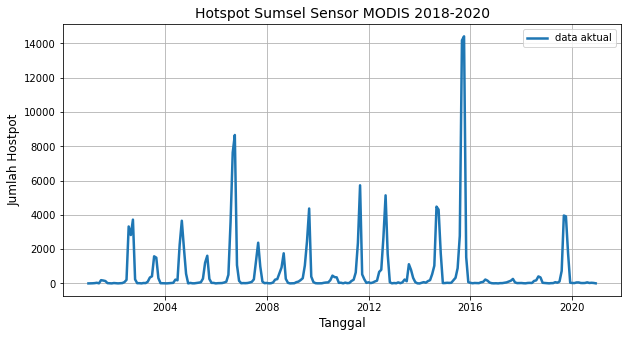

In [11]:
# generate urutan data sesuai panjang datanya
x = pd.date_range(start="2001-01-01", periods=len(df_sumsel), freq='MS')

# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(x, df_sumsel, color="tab:blue", label="data aktual", linewidth=2.5)

# membuat label-label
ax.set_title("Hotspot Sumsel Sensor MODIS 2018-2020", fontsize=14)
ax.set_xlabel("Tanggal", fontsize=12)
ax.set_ylabel("Jumlah Hostpot", fontsize=12)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

### Normalisasi Data

In [12]:
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
df_sumsel = scaler.fit_transform(df_sumsel)

In [13]:
np.round(df_sumsel[:5],6)

array([[-0.999723],
       [-0.999445],
       [-0.998751],
       [-0.997364],
       [-0.994728]], dtype=float32)

### Data Latih dan Data Uji

In [14]:
# split into train and test sets
train_size = int(len(df_sumsel) * 0.8)
test_size = len(df_sumsel) - train_size
train, test = df_sumsel[0:train_size,:], df_sumsel[train_size:len(df_sumsel),:]

In [15]:
print(train.shape, test.shape)

(192, 1) (48, 1)


### Supervised Learning

In [16]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [17]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [18]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [19]:
print(trainX.shape, testX.shape)

(190, 1, 1) (46, 1, 1)


In [20]:
print(testY.shape, testY.shape)

(46,) (46,)


### Model LSTM-RNN

- Kondisi Hyperparameter

In [21]:
# design network
model = Sequential()
model.add(LSTM(units=10, activation='selu', input_shape=(1, look_back)))
model.add(Dropout(0.2))
model.add(Dense(1))

# model compile
model.compile(optimizer=SGD(), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# fit network
history = model.fit(trainX, trainY, epochs=2000, batch_size=8,
                    validation_data=(testX, testY),
                    verbose=0, shuffle=False)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


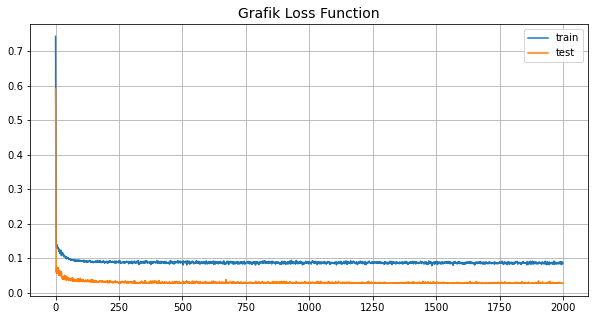

In [23]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(history.history['loss'], color="tab:blue", label="train", linewidth=1.5)
ax.plot(history.history['val_loss'], color="tab:orange", label="test", linewidth=1.5)

# membuat label-label
ax.set_title("Grafik Loss Function", fontsize=14)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

In [24]:
# 5. make predictions
predictions = model.predict(testX, verbose=0)
print(predictions[:, 0])

[-0.9978079  -0.9982692  -0.9974491  -0.99739784 -0.9963211  -0.9952439
 -0.9925733  -0.9875735  -0.97660977 -0.9952952  -0.9973466  -0.9970902
 -0.9970902  -0.99775666 -0.99801296 -0.9969364  -0.99668    -0.9969877
 -0.98871654 -0.9849734  -0.9620124  -0.9677288  -0.9964749  -0.9970902
 -0.99791044 -0.9980642  -0.99750036 -0.9973466  -0.9945769  -0.9961672
 -0.99182665 -0.9321084  -0.6975455  -0.7003752  -0.8477379  -0.9961672
 -0.99703896 -0.99719274 -0.9953978  -0.9953465  -0.99703896 -0.99719274
 -0.9969364  -0.99509    -0.9969364  -0.99637234]


### Evaluasi Model LSTM-RNN

- RMSE

In [25]:
scores = model.evaluate(trainX, trainY)
scores

6/6 [==============================] - 0s 3ms/step - loss: 0.0837 - root_mean_squared_error: 0.2190


[0.0836690217256546, 0.2190396636724472]

In [26]:
scores = model.evaluate(testX, testY)
scores

2/2 [==============================] - 0s 0s/step - loss: 0.0274 - root_mean_squared_error: 0.0844


[0.02739090472459793, 0.08442743867635727]

In [27]:
# calculate RMSE
rmse = sqrt(mean_squared_error(testY, predictions))
print('Test RMSE: %.4f' % rmse)

Test RMSE: 0.0844


- Korelasi dan Signifikansi

In [28]:
hasil = np.stack((testY.reshape(-1),predictions.reshape(-1)),axis=1)
hasil = pd.DataFrame(hasil, columns = ['data_aktual','prediksi'])
hasil.head()

,data_aktual,prediksi
0,-0.999723,-0.997808
1,-0.997503,-0.998269
2,-0.997364,-0.997449
3,-0.994450,-0.997398
4,-0.991537,-0.996321


In [29]:
import scipy.stats as sc
r, p = sc.pearsonr(hasil["data_aktual"], hasil["prediksi"])
print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r)+ "dengan signifikansi" +" {:.4f} ".format(p))

korelasi data akual dengan hasil prediksi 0.7051 dengan signifikansi 0.0000 


- Waktu komputasi

In [30]:
# Set akhir waktu komputasi 
end = time.time()

In [31]:
# Proses menghitung waktu komputasi
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)

In [32]:
# Hasil waktu komputasi
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:03:27.03


### Visualisasi Data

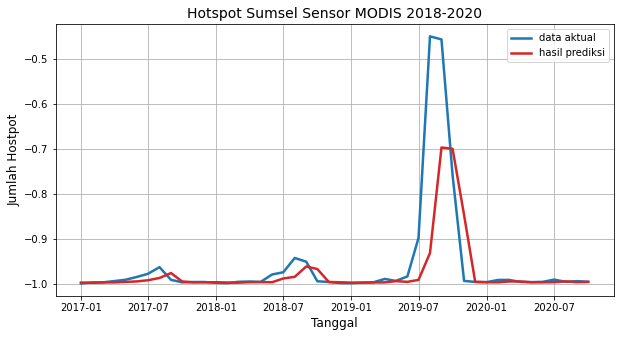

In [33]:
# generate urutan data sesuai panjang datanya
x = pd.date_range(start="2017-01-01", periods=len(testY), freq='MS')

# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(x, testY, color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(x, predictions, color="tab:red", label="hasil prediksi", linewidth=2.5)

# membuat label-label
ax.set_title("Hotspot Sumsel Sensor MODIS 2018-2020", fontsize=14)
ax.set_xlabel("Tanggal", fontsize=12)
ax.set_ylabel("Jumlah Hostpot", fontsize=12)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()